In [7]:
# --- Interactive plotting for basic dyslexia center data overview --- #
# Import libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
import ipywidgets as widgets
from IPython.display import display, Markdown, Javascript
from IPython.core.display import display, HTML, Image
import regex as re
from enum import Enum

sys.path.append('/Users/mkersey/code/REDCap_tools/')
from redcap_tools.import_data import (import_data_redcap, import_redcap_metadata, import_redcap_report)
from IPython.core.display import display, HTML

sys.path.append('/Users/mkersey/code/neuro_predictor/code')
from neuro_predictor.data_curation import get_diagnosis, get_mri, get_batteries

from ucsfneuroviz.importer import import_dataframe, read_csv_as_list
from ucsfneuroviz.interactive_behav_plots import interactive_heatmap, interactive_radar, interactive_line_plot, interactive_individual_line_plot
from ucsfneuroviz.interactive_struct_plots import interactive_brain_zscore_plot, activate_selected_font
from ucsfneuroviz.utils import extract_dc_diagnoses
from ucsfneuroviz.fc_vars import FC_vars, FC_vars_select

display(HTML('<link rel="stylesheet" href="custom/style_stats.css">'))

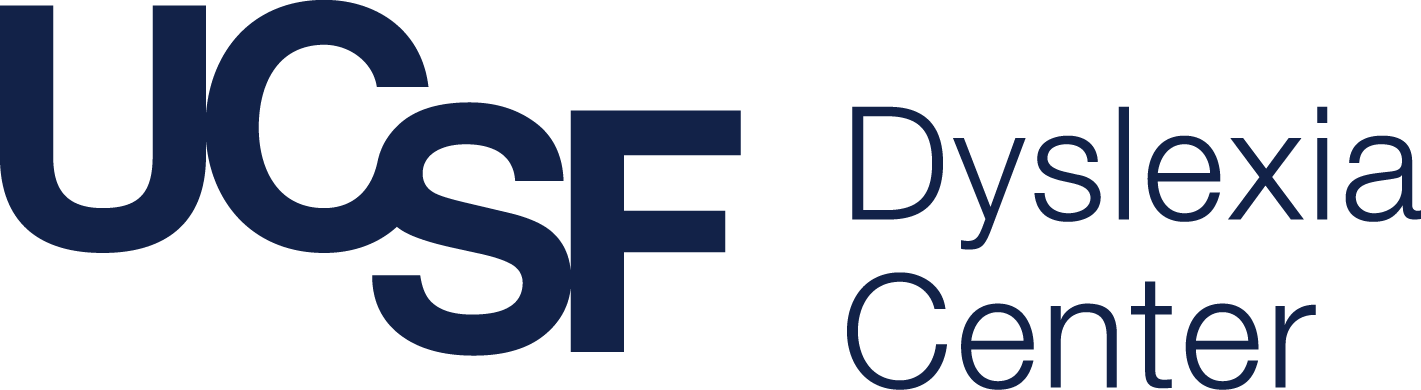

In [8]:
# Insert photo from ./assets/ folder
Image(filename='./assets/UCSF_sublogo_DyslexiaCenter_navy_RGB.png', width=250)

In [5]:
class TabIndex(Enum):
    BATTERY = 0
    TASK = 1

class REDCapAnalysis:
    # Class constants
    WIDGET_WIDTH = '400px'
    PROGRESS_MAX = 10
    
    def __init__(self, diagnosis_columns, battery_columns, battery_breakdown_path):
        # Initialize widgets
        self._initialize_widgets(diagnosis_columns)
        
        # Initialize diagnosis dropdown observers
        self.diagnosis_dropdown_tab1.observe(self.update_checkboxes, names='value')
        self.diagnosis_dropdown_tab2.observe(self.update_checkboxes, names='value')
        
        # Initialize data-related instance variables
        self._initialize_data_related_vars(battery_columns, battery_breakdown_path)
        
        # Display widgets
        self._display_widgets()

        # Initialize data and plots for tab2
        self._update_tab(TabIndex.TASK)

    def _initialize_widgets(self, diagnosis_columns):
        self.token_input = widgets.Password(
            value='',
            placeholder='Enter REDCap token',
            description='Data Token:',
            disabled=False,
            layout=widgets.Layout(width=self.WIDGET_WIDTH)
        )
        self.submit_token = widgets.Button(
            description='Submit',
            disabled=False,
            tooltip='Submit REDCap token',
            icon='check'
        )
        self.progress_description = widgets.Label(
            value='',
            layout=widgets.Layout(width='100px')
        )
        self.progress = widgets.IntProgress(
            value=0,
            min=0,
            max=self.PROGRESS_MAX,
            step=1,
            bar_style='',
            orientation='horizontal'
        )
        self.diagnosis_dropdown_tab1 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )
        self.diagnosis_dropdown_tab2 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )

        # Initialize output widgets
        self.out_checkbox_battery = widgets.Output()
        self.out_checkbox_task = widgets.Output()
        self.out_plot_battery = widgets.Output()
        self.out_plot_task = widgets.Output()
        
        # Tab widgets
        self.battery_tab = widgets.VBox([self.diagnosis_dropdown_tab1, self.out_checkbox_battery, self.out_plot_battery])
        self.task_tab = widgets.VBox([self.diagnosis_dropdown_tab2, self.out_checkbox_task, self.out_plot_task])

        self.tabs = widgets.Tab(children=[self.battery_tab, self.task_tab])
        self.tabs.set_title(0, 'Battery Completion')
        self.tabs.set_title(1, 'Task Completion')
 
    def _initialize_data_related_vars(self, battery_columns, battery_breakdown_path):
        self.diagnosis_checkboxes = {}
        self.task_checkboxes = {}
        self.battery_checkboxes = {}
        self.battery_columns = battery_columns
        self.battery_breakdown_path = battery_breakdown_path
    
    def _display_widgets(self):
        display(widgets.HBox([self.token_input, self.submit_token, self.progress_description, self.progress]))
        display(self.tabs)
    

    


In [6]:

class REDCapAnalysis:
    activate_selected_font('EB Garamond', 'EBGaramond-Regular.ttf')

    def __init__(self, diagnosis_columns, battery_columns, battery_breakdown_path):
        # Initialize widgets related to REDCap token and progress bar
        self.token_input = widgets.Password(
            value='',
            placeholder='Enter REDCap token',
            description='Data Token:',
            disabled=False,
            layout=widgets.Layout(width='400px')
        )
        self.submit_token = widgets.Button(
            description='Submit',
            disabled=False,
            tooltip='Submit REDCap token',
            icon='check'
        )
        self.progress_description = widgets.Label(
            value='',
            layout=widgets.Layout(width='100px')
        )
        self.progress = widgets.IntProgress(
            value=0,
            min=0,
            max=10,
            step=1,
            bar_style='',
            orientation='horizontal'
        )

        # Link the submit button to the get_redcap_data function
        self.submit_token.on_click(self.get_redcap_data)
        # Link the progress bar to the submit button
        # self.submit_token.on_click(self.progress) # GPT said to remove this bc it's not doing what I expect it to do

        # Initialize diagnosis dropdown
        self.diagnosis_dropdown_tab1 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )
        self.diagnosis_dropdown_tab1.observe(self.update_checkboxes, names='value')
         
        # Initialize a second diagnosis dropdown for the second tab
        self.diagnosis_dropdown_tab2 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )
        self.diagnosis_dropdown_tab2.observe(self.update_checkboxes, names='value')

        # Initialize output widgets
        self.out_checkbox_battery = widgets.Output()
        self.out_checkbox_task = widgets.Output()
        self.out_plot_battery = widgets.Output()
        self.out_plot_task = widgets.Output()
        
        # Tab widgets
        self.battery_tab = widgets.VBox([self.diagnosis_dropdown_tab1, self.out_checkbox_battery, self.out_plot_battery])
        self.task_tab = widgets.VBox([self.diagnosis_dropdown_tab2, self.out_checkbox_task, self.out_plot_task])

        # Initialize task checkboxes to use used for task tab and additional checkboxes for battery tab
        self.diagnosis_checkboxes = {}
        self.task_checkboxes = {}
        self.battery_checkboxes = {}
        # Initialize additional columnns to generate boxes for battery tab
        self.battery_columns = battery_columns
        
        self.tabs = widgets.Tab(children=[self.battery_tab, self.task_tab])
        self.tabs.set_title(0, 'Battery Completion')
        self.tabs.set_title(1, 'Task Completion')
        self.tabs.observe(self.handle_tab_change, names='selected_index')

        self.battery_breakdown_path = battery_breakdown_path

        # Display widgets
        display(widgets.HBox([self.token_input, self.submit_token, self.progress_description, self.progress]))
        display(self.tabs)

        change_dict_tab2 = {'new': self.diagnosis_dropdown_tab2.value, 'owner': self.diagnosis_dropdown_tab2}
        self.update_checkboxes(change_dict_tab2)
        self.plot_stats(change_dict_tab2)

    def handle_tab_change(self, change):
        new_index = change['new']
        if new_index == 1:  # 1 is the index of "Task Completion" tab
            # Explicitly set the triggering widget and value for the second tab
            change_dict = {'new': self.diagnosis_dropdown_tab2.value, 'owner': self.diagnosis_dropdown_tab2}

            self.update_checkboxes(change_dict)
            self.plot_stats(change_dict)

    def modify_label_for_plotting(self):
        self = re.sub(
            "Percentile:|\\?|Done|Completed|Date:|Overall % Correct:|Total:|:",
            "",
            self,
        )
        self = re.sub(r'\([^)]*\)', '', self)
        self = re.sub("Woodcock Johnson Test of Achievement", "WCJ", self)
        self = re.sub("Woodcock Johnson Test of Oral Language", "WCJ", self)
        return self
    
    def update_checkboxes(self, change):
        # Add this line to check if redcap_labels is available
        if not hasattr(self, 'redcap_labels'):
            return
        
        # CSS to left-align text and minimize width
        left_align_style = "<style>.widget-label { text-align: left !important; }</style>"
        display(HTML(left_align_style))

        # Clear the output widgets
        self.out_checkbox_battery.clear_output(wait=True)
        self.out_checkbox_task.clear_output(wait=True)

        # Extract triggering_widget and selected_diagnosis_column
        triggering_widget = change.get('owner', None)
        selected_diagnosis_column = change.get('new', None)

        # Clear the plot when diagnosis dropdown changes
        if triggering_widget == self.diagnosis_dropdown_tab1:
            with self.out_plot_battery:
                self.out_plot_battery.clear_output()
        elif triggering_widget == self.diagnosis_dropdown_tab2:
            with self.out_plot_task:
                self.out_plot_task.clear_output()

        # Determine the active tab using selected_index
        active_tab_index = self.tabs.selected_index  # Get the index of the active tab
        
        # Then use this index to set 'out_checkbox' and 'tab'
        if active_tab_index == 0:
            # out_checkbox = self.out_checkbox_battery
            tab = 'battery_tab'
        elif active_tab_index == 1:
            # out_checkbox = self.out_checkbox_task
            tab = 'task_tab'
        else:
            return  # Exit if the triggering widget is neither of the dropdowns

        print(f"triggering_widget: {triggering_widget}")
        print(f"selected_diagnosis_column: {selected_diagnosis_column}")
        
        print(f"ID of diagnosis_dropdown_tab1: {id(self.diagnosis_dropdown_tab1)}")
        print(f"ID of diagnosis_dropdown_tab2: {id(self.diagnosis_dropdown_tab2)}")



        # Initialize list to store checkboxes
        all_columns_boxes = []

        checkbox_layout = widgets.Layout(margin='0 0 0 -80px')

        # Create diagnosis checkboxes
        if selected_diagnosis_column != "All Children":
            unique_values = self.redcap_labels[selected_diagnosis_column].dropna().unique()
            diagnosis_checkboxes = [widgets.Checkbox(value=False, description=str(val), layout=checkbox_layout) for val in unique_values]
            for checkbox in diagnosis_checkboxes:
                checkbox.observe(self.plot_stats, names='value')
            diagnosis_label = widgets.Label(value='Diagnosis')
            diagnosis_box = widgets.VBox([diagnosis_label, widgets.VBox(diagnosis_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
            all_columns_boxes.append(diagnosis_box)

            # Store checkboxes
            self.diagnosis_checkboxes[selected_diagnosis_column] = diagnosis_checkboxes
        
        # Create "All Children" checkbox
        if selected_diagnosis_column == "All Children":
            print("All Children selected")
            print(tab==self.task_tab)
            diagnosis_checkboxes = [widgets.Checkbox(value=True, description="All Children", layout=checkbox_layout)]
            for checkbox in diagnosis_checkboxes:
                checkbox.observe(self.plot_stats, names='value')
            diagnosis_label = widgets.Label(value='Diagnosis')
            diagnosis_box = widgets.VBox([diagnosis_label, widgets.VBox(diagnosis_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
            all_columns_boxes.append(diagnosis_box)
            
            # Store checkboxes
            self.diagnosis_checkboxes[selected_diagnosis_column] = diagnosis_checkboxes
        

        # Additional checkboxes for the Battery tab
        if tab == 'battery_tab':
            for col in self.battery_columns:
                unique_values = self.redcap_labels[col].dropna().unique()
                battery_checkboxes = [widgets.Checkbox(value=False, description=str(val), layout=checkbox_layout) for val in unique_values]
                for checkbox in battery_checkboxes:
                    checkbox.observe(self.plot_stats, names='value')
                col_label = widgets.Label(value=f"{col}")
                col_box = widgets.VBox([col_label, widgets.VBox(battery_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
                all_columns_boxes.append(col_box)

                # Store checkboxes
                self.battery_checkboxes[col] = battery_checkboxes

            with self.out_checkbox_battery:
                display(widgets.HBox(all_columns_boxes, layout=widgets.Layout(align_items='flex-start')))

        # Task checkboxes (Task tab only)
        elif tab == 'task_tab':
            # Add "MRI Acquired" category from battery_columns
            category='MRI Acquired'
            unique_values = self.redcap_labels[category].dropna().unique()
            battery_checkboxes = [widgets.Checkbox(value=False, description=str(val), layout=checkbox_layout) for val in unique_values]
            for checkbox in battery_checkboxes:
                checkbox.observe(self.plot_stats, names='value')
            col_label = widgets.Label(value=category)
            col_box = widgets.VBox([col_label, widgets.VBox(battery_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
            all_columns_boxes.append(col_box)

            self.battery_checkboxes[category] = battery_checkboxes

            for category, tasks in self.battery_breakdown[self.battery_breakdown['Checkbox'] == 'YES'].groupby('Browser Category')['Redcap Variable Name']:
                task_checkboxes = []
                for task in tasks:
                    task_label = self.dict_labels.get(task, task)
                    if pd.isna(task_label):
                        continue  # Skip if the label is nan

                    checkbox = widgets.Checkbox(value=False, description=str(task_label), disabled=False, layout=checkbox_layout)
                    task_checkboxes.append(checkbox)
                    checkbox.observe(self.plot_stats, names='value')
                category_label = widgets.Label(value=category)
                category_box = widgets.VBox([category_label, widgets.VBox(task_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
                all_columns_boxes.append(category_box)

                # Store checkboxes as instance variables
                self.task_checkboxes[category] = task_checkboxes

            with self.out_checkbox_task:
                display(widgets.HBox(all_columns_boxes, layout=widgets.Layout(align_items='flex-start')))


    def get_redcap_data(self, button):

        self.dict_labels = {}  # Initialize dict_labels
        # Pull REDCap data from the token
        
#         self.redcap_labels = pd.read_csv('/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/data/DyslexiaProject_VISITONE-PHENO_DATA_LABELS_2023-09-11.csv')
        self.redcap_labels = pd.read_csv('/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/data/DyslexiaProject_VISITONE-PHENO_DATA_LABELS_2023-09-11_widget.csv')
        self.redcap_raw = pd.read_csv('/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/data/DyslexiaProject-VISITONE-PHENO_DATA_RAW_2023-09-11.csv')
        display(self.redcap_labels)
        display(self.redcap_raw)
        # try:

        #     # Initialize progress bar
        #     self.progress.value = 0
        #     self.progress.max = 10
        #     self.progress_description.value = 'Starting...'

        #     # Step 1: Get token and initialize progress
        #     token = self.token_input.value
        #     self.progress.value += 1
        #     self.progress_description.value = 'Token received...'

        #     # Step 2: Fetch REDCap label data
        #     # self.redcap_labels = import_data_redcap(token, data='label', headers='label')
        #     self.progress.value += 3
        #     self.progress_description.value = 'Label data fetched...'

        #     # Step 3: Fetch REDCap raw data
        #     # self.redcap_raw = import_data_redcap(token, data='raw', headers='raw')
        #     self.progress.value += 3
        #     self.progress_description.value = 'Raw data fetched...'

        #     del token

        # except Exception as e:
        #     self.progress.bar_style = 'danger'
        #     self.progress_description.value = 'Failed'
        #     print(e)
            
        #     # If REDCap data cannot be loaded from the token, load in csv files from BOX
        #     self.redcap_labels = pd.read_csv('/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/data/DyslexiaProject_VISITONE-PHENO_DATA_LABELS_2023-09-11.csv')
        #     self.redcap_raw = pd.read_csv('/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/data/DyslexiaProject_VISITONE-PHENO_DATA_RAW_2023-09-11.csv')

        #     # HTML display "REDCap API data load failed - Loading data from BOX instead."
        #     display(HTML(f'<h3 style="color: #052049;">REDCap API data load failed - Loading older data from BOX instead.<br></h3>'))

        # Create a dictionary to map column names to labels
        self.dict_labels = dict(zip(self.redcap_raw.columns.values.tolist(), self.redcap_labels.columns.values.tolist()))

        # Add meaningful columns for diagnosis, MRI, and batteries
        df_tmp = self.redcap_raw.copy()
        df_tmp = get_diagnosis(df_tmp)
        df_tmp = get_mri(df_tmp)
        df_tmp = get_batteries(df_tmp)

        # Identify columns in df_tmp that are not in self.redcap_raw
        new_cols = df_tmp.columns.difference(self.redcap_raw.columns)
        
        # Add these columns to self.redcap_labels
        for col in new_cols:
            self.redcap_labels[col] = df_tmp[col]
        # Filter to phenotyping study participants only, and visit one only
        self.redcap_labels = self.redcap_labels[self.redcap_labels[self.dict_labels['project_category']]=='Pediatric Phenotyping']
        self.redcap_labels = self.redcap_labels[self.redcap_labels[self.dict_labels['redcap_event_name']]=='Visit One']

        # Read in the battery breakdown spreadsheet
        self.battery_breakdown = pd.read_excel(self.battery_breakdown_path, sheet_name='Sheet1')
        
        # Get the variables of interest
        self.all_checkbox_tasks = self.battery_breakdown[self.battery_breakdown['Checkbox']=='YES']['Redcap Variable Name'].values.tolist()
        self.primary_battery_pheno_tasks = self.battery_breakdown[self.battery_breakdown['Primary Phenotyping Battery (Pediatric)']=='YES']['Redcap Variable Name'].values.tolist()
        self.primary_battery_control_tasks = self.battery_breakdown[self.battery_breakdown['Primary Control Battery (Pediatric)']=='YES']['Redcap Variable Name'].values.tolist()

        cols_for_pheno_tasks = []
        cols_for_control_tasks = []

        # Get the column names for primary_battery_pheno_tasks from dict_labels
        for task in self.primary_battery_pheno_tasks:
            if task in self.dict_labels:  # Check if the key exists in the dictionary
                cols_for_pheno_tasks.append(self.dict_labels[task])

        # Get the column names for primary_battery_control_tasks from dict_labels
        for task in self.primary_battery_control_tasks:
            if task in self.dict_labels:  # Check if the key exists in the dictionary
                cols_for_control_tasks.append(self.dict_labels[task])

        # Add new columns based on the condition
        self.redcap_labels['Primary Phenotyping Battery\n(Pediatric)'] = \
            self.redcap_labels[cols_for_pheno_tasks].apply(lambda row: 'Yes' if row.notna().all() else 'No', axis=1)
        
        # save redcap_labels[cols_for_pheno_tasks] as a csv
#         self.redcap_labels[cols_for_pheno_tasks].to_csv('/Users/mkersey/Downloads/redcap_labels_pheno_tasks.csv')

        self.redcap_labels['Primary Control Battery\n(Pediatric)'] = \
            self.redcap_labels[cols_for_control_tasks].apply(lambda row: 'Yes' if row.notna().all() else 'No', axis=1)

        # Final step: Update plot and checkboxes
        # Inside the __init__ method, add the following lines at the end:
        self.update_checkboxes({'new': self.diagnosis_dropdown_tab1.value})
        self.plot_stats({'new': self.diagnosis_dropdown_tab1.value, 'owner': self.diagnosis_dropdown_tab1})

        self.update_checkboxes({'new': self.diagnosis_dropdown_tab2.value})
        self.plot_stats({'new': self.diagnosis_dropdown_tab2.value, 'owner': self.diagnosis_dropdown_tab2})

        # At the beginning of plot_stats method, add this line:
        if not hasattr(self, 'redcap_labels'):
            return

        self.progress.value = self.progress.max
        self.progress_description.value = 'All done. Nice!'


    def plot_stats(self, change=None):
        # Add this line to check if redcap_labels is available
        if not hasattr(self, 'redcap_labels'):
            return
            
        # Determine which dropdown triggered the change and which tab is active
        active_tab_index = self.tabs.selected_index  # Get the index of the active tab

        if isinstance(change, dict):  # check if change is a dictionary
            triggering_widget = change.get('owner', None)
        elif isinstance(change, str):  # check if change is a string
            triggering_widget = None
        else:
            return  # If change is neither a dictionary nor a string, exit the function

        if triggering_widget == self.diagnosis_dropdown_tab1 or active_tab_index == 0:
            diagnosis_dropdown_value = self.diagnosis_dropdown_tab1.value
            selected_battery_values = {col: [cb.description for cb in cbs if cb.value] for col, cbs in self.battery_checkboxes.items()}
            out_plot = self.out_plot_battery
            with self.out_plot_battery:
                self.out_plot_battery.clear_output(wait=True)
        elif triggering_widget == self.diagnosis_dropdown_tab2 or active_tab_index == 1:
            diagnosis_dropdown_value = self.diagnosis_dropdown_tab2.value
            selected_battery_values = {col: [cb.description for cb in cbs if cb.value] for col, cbs in self.battery_checkboxes.items()}
            selected_task_values = {category: [cb.description for cb in cbs if cb.value] for category, cbs in self.task_checkboxes.items()}
            out_plot = self.out_plot_task
            with self.out_plot_task:
                self.out_plot_task.clear_output(wait=True)
        else:
            return  # If the triggering widget is neither of the dropdowns, exit the function

        with out_plot:
            
            if diagnosis_dropdown_value == "All Children":
                df_filtered = self.redcap_labels.copy()
            else:
                selected_diagnoses = [cb.description for cb in self.diagnosis_checkboxes.get(diagnosis_dropdown_value, []) if cb.value]
                if not selected_diagnoses:
                    return
                df_filtered = self.redcap_labels[self.redcap_labels[diagnosis_dropdown_value].isin(selected_diagnoses)]
                df_filtered = df_filtered[df_filtered[diagnosis_dropdown_value].notna()]

            if out_plot == self.out_plot_battery:
                # Filter by battery checkboxes first
                for col in self.battery_checkboxes.keys():
                    selected_values = selected_battery_values[col]
                    if selected_values:
                        df_filtered = df_filtered[df_filtered[col].isin(selected_values)]
                        df_filtered = df_filtered[df_filtered[col].notna()]

            elif out_plot == self.out_plot_task:
                
                # Filter by battery checkboxes first
                for col in self.battery_checkboxes.keys():
                    selected_values = selected_battery_values[col]
                    if selected_values:
                        df_filtered = df_filtered[df_filtered[col].isin(selected_values)]
                        df_filtered = df_filtered[df_filtered[col].notna()]

                for category in self.task_checkboxes.keys():
                    selected_values = selected_task_values.get(category, [])

                    if selected_values:
                        # Make sure selected_values contains the correct columns
                        df_filtered = df_filtered[df_filtered[selected_values].notna().all(axis=1)]

            # Check if there are any subjects left
            if df_filtered.shape[0] == 0:
                # If not, display a message and return
                display(HTML(f'<h3 style="color: #052049;">No subjects found with the selected criteria.<br></h3>'))
                return

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))

            # add a suptitle to the figure: Total Participants: {df_filtered.shape[0]}
            fig.suptitle(f'Total Participants Selected: {df_filtered.shape[0]}', fontsize=20)
            # add some padding under the suptitle
            fig.subplots_adjust(top=.85)

            # Plot the counts in each diagnosis group
            if diagnosis_dropdown_value == 'All Children':
                # Simply count the number of rows and plot a single bar
                sns.barplot(x=['All Children'], y=[len(df_filtered)], ax=ax[0], zorder=1)
                ax[0].set_title('Total Children', fontsize=18)
                ax[0].set_xlabel('All Children', fontsize=16)
                # take away x-tick labels
                ax[0].set_xticklabels([])
            else:
                # Use sns.countplot to count the occurrences of each unique value in the selected column
                sns.countplot(data=df_filtered, x=diagnosis_dropdown_value, ax=ax[0], zorder=1)
                ax[0].set_title('Diagnosis', fontsize=20)
                ax[0].set_xlabel('Diagnosis', fontsize=16)
            ax[0].set_ylabel('Count', fontsize=16)

            # Age (neuropsych)
            df_filtered['age_neuropsych_int'] = df_filtered[self.dict_labels['age_neuropsych']].apply(lambda x: int(x) if not pd.isna(x) else x)
            sns.countplot(data=df_filtered, x='age_neuropsych_int', ax=ax[1], zorder=1)
            ax[1].set_title('Age', fontsize=18)
            ax[1].set_xlabel('Age', fontsize=16)
            ax[1].set_ylabel('', fontsize=16)
            ax[1].set_xticklabels([int(float(tick.get_text())) for tick in ax[1].get_xticklabels()])
            # add counts above bars

            # Sex
            # change 1 to Male, 2 to Female, 3 to Other
            # df_filtered.loc[:, 'sex'] = df_filtered['sex'].apply(lambda x: 'Male' if x == 1 else 'Female' if x == 2 else 'Other' if x == 3 else x)
            sns.countplot(data=df_filtered, x=self.dict_labels['sex'], ax=ax[2], order=['Male', 'Female', 'Other'], zorder=1)
            ax[2].set_title('Sex', fontsize=18)
            ax[2].set_xlabel('Sex', fontsize=16)
            ax[2].set_ylabel('', fontsize=16)

            # Handedness
            # df_filtered.loc[:, 'handedness'] = df_filtered['handedness'].apply(lambda x: 'Non-right' if x == 1 else 'Right' if x == 2 else 'Unknown' if x == 3 else x)
            sns.countplot(data=df_filtered, x=self.dict_labels['handedness'], ax=ax[3], order=['Right', 'Non-Right', 'Unknown'], zorder=1)
            ax[3].set_title('Handedness', fontsize=18)
            ax[3].set_xlabel('Handedness', fontsize=16)
            ax[3].set_ylabel('', fontsize=16)

            # add counts on top of bars in the middle of the bar
            for subplot in ax:
                for p in subplot.patches:
                    subplot.annotate(
                        str(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', 
                        va='center', 
                        xytext=(0, 8), 
                        textcoords='offset points',
                        # make size of text larger
                        fontsize=14
                    )

            # add horizontal lines behind the bars at each y-tick
            for subplot in ax:
                for ytick in subplot.get_yticks():
                    subplot.axhline(ytick, linestyle='-', alpha=0.25, color='grey', zorder=0)

            # Add a line of text at the very bottom left side: "Note: Pediatric Phenotyping Study - Visit One"
            fig.text(0.1, -0.05, 'Note: Pediatric Phenotyping Study - Visit One', fontsize=14)

            # display(plt.show())
            plt.show()
            # print("Plot stats finished")

# List of diagnosis columns to choose from
diagnosis_columns = ['All Children', 'Diagnosis Overall', 'Dyslexia and ADHD', 'Dyslexia Phenotype', 'Dyslexia Phenotype Short', 'Dyslexia and Dyscalculia', 'Dyslexia and MLD', 'MLD Subtype Primary', 'MLD Subtype Secondary']
battery_columns = ['MRI Acquired', 'Primary Phenotyping Battery\n(Pediatric)', 'Primary Control Battery\n(Pediatric)']

# Load in battery breakdown spreadsheet
battery_breakdown_path = '/Users/mkersey/Library/CloudStorage/Box-Box/Dyslexia RC Documents/Administering, Testing Stimuli, Scoring/Full_List_of_Batteries_and_Tests.xlsx'

# Create an instance of REDCapAnalysis with the list of diagnosis columnss
redcap_analysis = REDCapAnalysis(diagnosis_columns, battery_columns, battery_breakdown_path)

/var/folders/9r/l5byf96j5qv7bx1hlzlkwz7h0000gp/T/ipykernel_87154/1271049665.py:244: DtypeWarning: Columns (7,11,15,20,22,24,27,29,43,59,60,61,80,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,105,106,111,112,113,114,115,117,118,119,124,125,198,201,202,205,216,217,218,289,411,439,440,491,492,500,501,502,503,504,505,506,511,512,514,515,516,517,518,519,538,539,585,586,587,588,589,592,598,610,612,614,640,647,648,649,654,655,663,691,719,721,722,723,724,725,733,734,777,785,793,794,795,796,807,810,811,812,819,821,823,825,826,827,851,863,864,865,866,876,877,879,880,881,882,885,888,891,894,896,899,903,906,910,914,918,922,927,931,935,940,943,947,950,953,956,959,962,965,968,971,974,976,977,978,979,982,1098,1101,1107,1112,1114,1117,1118,1135,1136,1137,1143,1144,1145,1146,1147,1148,1153,1154,1155,1157,1161,1162,1177,1181,1182,1183,1184,1185,1186,1187,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1209,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226

,ID Number,Event Name,MAC PIDN #:,Date of Birth:,Sex:,"If other sex, please state:",Gender:,"If other gender, please state:",Handedness:,EHI - Score:,...,Date of Math Battery Completion:.1,Overall Impression of Subject:.1,Additional Notes:.1,Does this participant have suspected Math Learning Difficulties (MLD)?.1,MLD Irreconcilable:.1,Numbers:.1,Calculations:.1,Arithmetic Facts:.1,Visuospatial/Geometry:.1,Complete?.42
0,1,Visit One,1.0,1/1/11,Male,NaN,Female,NaN,Right,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
1,16365,Visit One,16365.0,8/12/04,Female,NaN,Female,NaN,Right,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
2,16394,Visit One,16394.0,4/1/02,Female,NaN,Female,NaN,Right,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
3,17065,Visit One,17065.0,4/15/00,Female,NaN,Female,NaN,Right,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
4,17066,Visit One,17066.0,9/16/98,Female,NaN,Female,NaN,Right,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,35030,Visit One,35030.0,9/4/12,Male,NaN,Male,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
566,35059,Visit One,35059.0,8/10/10,Female,NaN,NaN,NaN,NaN,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
567,35060,Visit One,35060.0,9/8/09,Female,NaN,Female,NaN,Right,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
568,35069,Visit One,35069.0,3/12/15,Female,NaN,NaN,NaN,NaN,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete


,id_number,redcap_event_name,pidn,dob,sex,sex_other,gender,gender_other,handedness,ehi_score,...,dsb1_date,dsb1_impressions,dsb1_add_notes,dsb1_mld,dsb1_mld_irreconcilable,dsb1_mld_numbers,dsb1_mld_calculation,dsb1_mld_arithfacts,dsb1_mld_visuospatial,dyscalculia_subtyping_battery_1_entry_form_complete
0,1,visit_one_arm_1,1.0,1/1/11,1,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,16365,visit_one_arm_1,16365.0,8/12/04,2,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,16394,visit_one_arm_1,16394.0,4/1/02,2,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,17065,visit_one_arm_1,17065.0,4/15/00,2,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,17066,visit_one_arm_1,17066.0,9/16/98,2,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,35030,visit_one_arm_1,35030.0,9/4/12,1,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
566,35059,visit_one_arm_1,35059.0,8/10/10,2,NaN,NaN,NaN,NaN,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
567,35060,visit_one_arm_1,35060.0,9/8/09,2,NaN,2.0,NaN,2.0,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
568,35069,visit_one_arm_1,35069.0,3/12/15,2,NaN,NaN,NaN,NaN,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


triggering_widget: None
selected_diagnosis_column: All Children
ID of diagnosis_dropdown_tab1: 10761673312
ID of diagnosis_dropdown_tab2: 10761671776
All Children selected
False


triggering_widget: None
selected_diagnosis_column: All Children
ID of diagnosis_dropdown_tab1: 10761673312
ID of diagnosis_dropdown_tab2: 10761671776
All Children selected
False
